<a href="https://colab.research.google.com/github/Anubhav3084/Deep-Learning/blob/main/PyTorch_Tutorial/GANs/Image_Generation_using_DCGANs_AnimeFaceDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Generative Adversairal Networks and Transfer Learning**

### **Data Preprocessing**

In [1]:
!pip install opendatasets --upgrade --quiet

import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/splcher/animefacedataset'
od.download(dataset_url)

100%|██████████| 395M/395M [00:03<00:00, 124MB/s]


In [2]:
import os

DATA_DIR = './animefacedataset/'
print(os.listdir(DATA_DIR))
print(os.listdir(DATA_DIR + '/images')[:10])

['images']
['32829_2011.jpg', '62093_2019.jpg', '3516_2002.jpg', '8076_2004.jpg', '20690_2008.jpg', '47631_2014.jpg', '62258_2019.jpg', '21317_2008.jpg', '32098_2010.jpg', '54385_2016.jpg']


In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [7]:
image_size = 64         # 64 x 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # we fixed to means and std_devs for each channel

In [10]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=3, 
                      pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def denorm(image_tensors):
    return image_tensors * stats[1][0] + stats[0][0]

In [13]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


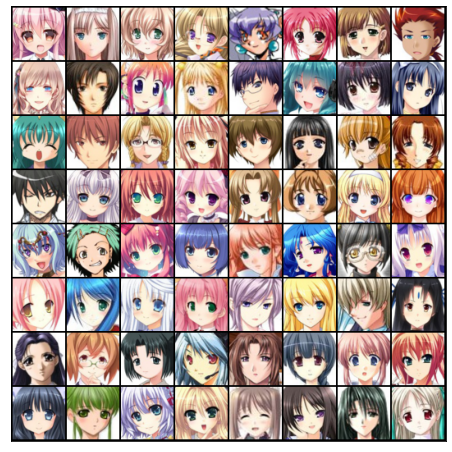

In [15]:
show_batch(train_dl)

### **GPU Utilities**

In [16]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
train_dl = DeviceDataLoader(train_dl, device)

### **Model**

#### **Discriminator Model**

In [20]:
import torch.nn as nn

In [23]:
discriminator = nn.Sequential(
    # input: batch_size x 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # output: batch_size x 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # output: batch_size x 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # output: batch_size x 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # output: batch_size x 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # output: batch_size x 1 x 1 x 1
    # this is also reducing the 512 channels to 1 channel

    nn.Flatten(),
    nn.Sigmoid()
)

In [27]:
from torchsummary import summary

discriminator = to_device(discriminator, device)
summary(discriminator, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
          Flatten-14                   

#### **Generator Model**
* We have to do the reverse of convolution
* We will use `convTranspose2d` layer
    * This performs transposed convolution (also referred to as a deconvolution)

In [28]:
latent_size = 128

In [41]:
generator = nn.Sequential(
    # input: batch_size x latent_size x 1 x 1
    
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # output: batch_size x 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # output: batch_size x 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # output: batch_size x 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # output: batch_size x 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # force the pixel values to be in range (-1, 1), same range as the pixel intensity as generator
    # output: batch_size x 3 x 64 x 64
)

torch.Size([128, 128, 1, 1])
torch.Size([128, 3, 64, 64])


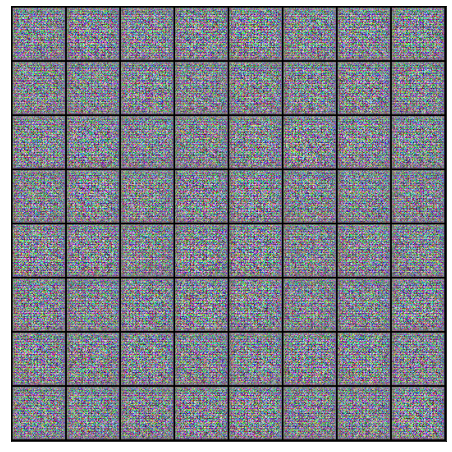

In [42]:
# print a random image by generator
xb = torch.randn(batch_size, latent_size, 1, 1)     # random latent tensors
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [43]:
generator = to_device(generator, device)
summary(generator, (128,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

### **Training**

#### **Discriminator Training**

In [44]:
import torch.nn.functional as F

In [45]:
def train_discriminator(real_images, opt_d):
    # clear discriminator gradients
    opt_d.zero_grad()

    # pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # pass fake images through discriminator
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score

#### **Generator Training**

In [46]:
def train_generator(opt_g):
    # clear generator gradients
    opt_g.zero_grad()

    # generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)  # we set target to 1 to fool the discriminator
    loss = F.binary_cross_entropy(preds, targets)

    # update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

### **Helper function for visualizing the proocess**

* Creating a directory to save images to visualize the progress.

In [47]:
from torchvision.utils import save_image

In [49]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [50]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-image-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))

* We fix the set of latent tensors so that we can keep track of the generated images and compare them

In [51]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

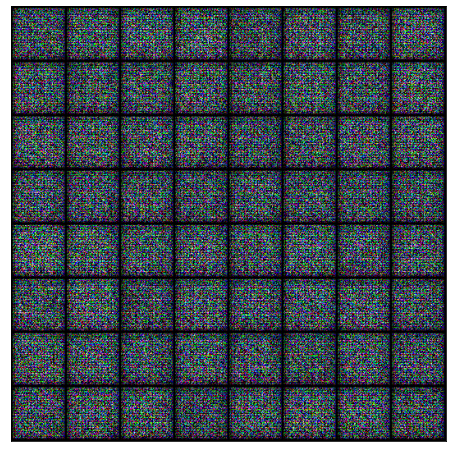

In [52]:
save_samples(0, fixed_latent)

### **Full Training Loop**

In [53]:
from tqdm.notebook import tqdm

In [54]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # losses and scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # train generator
            loss_g = train_generator(opt_g)

        # record losses and scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # log losses and scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch + 1, epochs, loss_g, loss_d, real_score, fake_score
        ))

        # save generated images
        save_samples(epoch + start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [55]:
lr = 0.0002
epochs = 25

In [56]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/25], loss_g: 5.3959, loss_d: 0.3668, real_score: 0.8894, fake_score: 0.1909


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 10.0819, loss_d: 1.1277, real_score: 0.9171, fake_score: 0.5943


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 2.9556, loss_d: 0.9623, real_score: 0.4885, fake_score: 0.0090


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 5.8154, loss_d: 0.2522, real_score: 0.9320, fake_score: 0.1457


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 8.3565, loss_d: 0.2420, real_score: 0.9455, fake_score: 0.1547


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 4.0800, loss_d: 0.0535, real_score: 0.9707, fake_score: 0.0194


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 6.8612, loss_d: 0.2011, real_score: 0.9307, fake_score: 0.1038


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 4.6564, loss_d: 0.1108, real_score: 0.9445, fake_score: 0.0459


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 4.8748, loss_d: 0.0242, real_score: 0.9880, fake_score: 0.0113


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 9.0810, loss_d: 0.0367, real_score: 0.9701, fake_score: 0.0010


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 7.0883, loss_d: 0.0854, real_score: 0.9759, fake_score: 0.0417


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 11.7950, loss_d: 0.2361, real_score: 0.9873, fake_score: 0.1775


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 6.1262, loss_d: 0.0743, real_score: 0.9894, fake_score: 0.0588


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 5.4596, loss_d: 0.1052, real_score: 0.9447, fake_score: 0.0187


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 9.0457, loss_d: 0.0417, real_score: 0.9974, fake_score: 0.0315


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 6.1827, loss_d: 0.0404, real_score: 0.9982, fake_score: 0.0368


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 8.7658, loss_d: 0.0863, real_score: 0.9977, fake_score: 0.0741


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 16.0239, loss_d: 0.3577, real_score: 0.9736, fake_score: 0.2384


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 12.4782, loss_d: 0.1146, real_score: 0.9416, fake_score: 0.0000


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 14.2090, loss_d: 0.2702, real_score: 0.9990, fake_score: 0.2179


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 24.9193, loss_d: 0.3118, real_score: 0.9929, fake_score: 0.1931


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 6.3296, loss_d: 0.0931, real_score: 0.9519, fake_score: 0.0372


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 15.8330, loss_d: 0.2744, real_score: 0.9969, fake_score: 0.1982


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 8.1407, loss_d: 0.1155, real_score: 0.9807, fake_score: 0.0838


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 11.4248, loss_d: 0.1928, real_score: 0.8776, fake_score: 0.0005


### **Save weights**

In [57]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

### **Convert the intermediate images into video for better visualization**

In [59]:
import cv2

vid_fname = 'gans_training.avi'
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MP4V'), 1, (530, 530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

### **Visualization of losses and scores**

In [60]:
losses_g, losses_d, real_scores, fake_scores = history

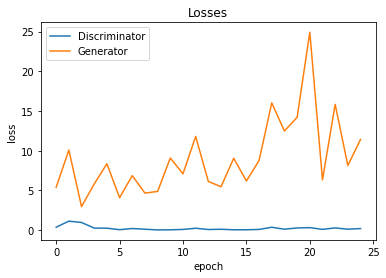

In [61]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

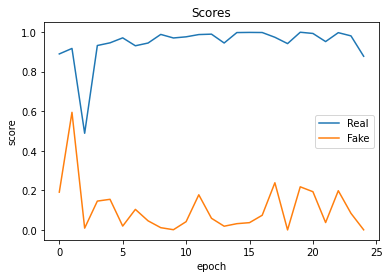

In [62]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');